# Model 3rd LOOCV ハイパーパラメータ最適化

Nadaraya-Watson推定のハイパーパラメータをLOOCV（Leave-One-Out Cross Validation）による定量的評価で最適化します。
複数の候補パラメータについて全期間でモデルを推定し、compositional data評価指標を計測して、
結果を箱ひげ図で比較し最適なパラメータを選択します。

## 1. ライブラリのインポート

In [1]:
import gc  # ガベージコレクション
import json
import os
import sys
from pathlib import Path

# パスの追加（必要に応じて調整）
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))

import japanize_matplotlib

japanize_matplotlib.japanize()
import time

# 警告の抑制
import warnings
from datetime import datetime
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from tqdm import tqdm

from bayesian_statistics.model3_config import Model3Config, Model3Pipeline
from bayesian_statistics.model3_loocv import LOOCVConfig, LOOCVEvaluator
from bayesian_statistics.model3_nadaraya_watson import NadarayaWatsonEstimator

warnings.filterwarnings("ignore")

# プロット設定
plt.style.use("default")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 12

# 初期メモリクリーンアップ
gc.collect()

print("ライブラリのインポート完了（メモリ効率化版）")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


ライブラリのインポート完了（メモリ効率化版）


## 2. 設定の定義

In [2]:
# データディレクトリの設定
data_dir = "/home/ohta/dev/bayesian_statistics/data/"

# 基本設定オブジェクトの作成
base_config = Model3Config(
    data_dir=data_dir,
    x_min=138,
    x_max=141,
    y_min=34,
    y_max=37,
    nw_sigma=500,  # これは候補の一つとして使用
    nw_sigma_for_sites=0.1,  # これも候補の一つとして使用
    mcmc_iterations=30000,
    burn_in=5000,
)

# LOOCV設定（メモリ効率のため試行回数を削減）
loocv_config = LOOCVConfig(
    n_trials=5,  # メモリ使用量を抑えるため5回に削減
    zero_replacement=1e-6,
    random_seed=42,
    save_intermediate=True,
    verbose=True,
)

print("設定内容:")
print(f"  データディレクトリ: {base_config.data_dir}")
print(
    f"  領域: [{base_config.x_min}, {base_config.x_max}] × [{base_config.y_min}, {base_config.y_max}]"
)
print(f"  LOOCV試行回数: {loocv_config.n_trials} (メモリ効率のため削減)")
print(f"  ランダムシード: {loocv_config.random_seed}")

設定内容:
  データディレクトリ: /home/ohta/dev/bayesian_statistics/data/
  領域: [138, 141] × [34, 37]
  LOOCV試行回数: 5 (メモリ効率のため削減)
  ランダムシード: 42


## 3. 前処理

In [3]:
# パイプラインの初期化
pipeline = Model3Pipeline(base_config)

# 前処理の実行
print("前処理を実行中...")
preprocessor = pipeline.run_preprocessing()
print("前処理完了")

前処理を実行中...
=== 前処理を開始 ===
データを読み込んでいます...
標高データ: (1357520, 42)
黒曜石データ: (30070, 11)
遺跡データ: (274, 49)
前処理完了


## 4. ハイパーパラメータ候補の設定

In [4]:
# ハイパーパラメータ候補の定義（メモリ効率のため候補数を削減）
sigma_candidates = [500, 700]  # グリッド間のカーネルバンド幅（削減）
sigma_for_sites_candidates = [0.01, 0.1, 1.0]  # 遺跡間のカーネルバンド幅（削減）

# 評価対象の時期（全期間で評価）
target_periods = list(base_config.time_periods.keys())

print("ハイパーパラメータ候補（メモリ効率のため削減）:")
print(f"  sigma候補: {sigma_candidates}")
print(f"  sigma_for_sites候補: {sigma_for_sites_candidates}")
print(f"  評価対象時期: {target_periods}")
print(
    f"  総候補数: {len(sigma_candidates) * len(sigma_for_sites_candidates)} 組み合わせ"
)

# パラメータ組み合わせ一覧表
print("\n【パラメータ組み合わせ一覧】")
print("組み合わせ番号 | sigma | sigma_for_sites")
print("-" * 40)
combination_counter = 0
parameter_combinations = []
for sigma in sigma_candidates:
    for sigma_for_sites in sigma_for_sites_candidates:
        combination_counter += 1
        parameter_combinations.append((sigma, sigma_for_sites))
        print(
            f"      {combination_counter:2d}       | {sigma:4d} |     {sigma_for_sites:.2f}"
        )

print(
    f"\n総実行時間見積もり: {len(parameter_combinations) * len(target_periods) * loocv_config.n_trials * 45 / 3600:.1f} 時間"
)
print("（1試行あたり約45秒と仮定、実際にはより効率的になる予定）")

ハイパーパラメータ候補（メモリ効率のため削減）:
  sigma候補: [500, 700]
  sigma_for_sites候補: [0.01, 0.1, 1.0]
  評価対象時期: [0, 1, 2, 3, 4]
  総候補数: 6 組み合わせ

【パラメータ組み合わせ一覧】
組み合わせ番号 | sigma | sigma_for_sites
----------------------------------------
       1       |  500 |     0.01
       2       |  500 |     0.10
       3       |  500 |     1.00
       4       |  700 |     0.01
       5       |  700 |     0.10
       6       |  700 |     1.00

総実行時間見積もり: 1.9 時間
（1試行あたり約45秒と仮定、実際にはより効率的になる予定）


## 5. ハイパーパラメータ評価システムの実装

In [5]:
import gc  # ガベージコレクション用


class HyperparameterEvaluator:
    """ハイパーパラメータ評価のためのクラス（メモリ効率化版）"""

    def __init__(self, preprocessor, base_config, loocv_config):
        self.preprocessor = preprocessor
        self.base_config = base_config
        self.loocv_config = loocv_config
        self.results = []

    def evaluate_single_parameter_set(self, sigma, sigma_for_sites, target_periods):
        """
        単一のパラメータセットを評価（メモリ効率化版）

        Parameters
        ----------
        sigma : float
            グリッド間のカーネルバンド幅
        sigma_for_sites : float
            遺跡間のカーネルバンド幅
        target_periods : list
            評価対象時期のリスト

        Returns
        -------
        dict
            評価結果
        """
        param_start_time = time.time()

        try:
            # 設定をコピーしてパラメータを更新
            model_config = Model3Config(
                data_dir=self.base_config.data_dir,
                x_min=self.base_config.x_min,
                x_max=self.base_config.x_max,
                y_min=self.base_config.y_min,
                y_max=self.base_config.y_max,
                nw_sigma=sigma,
                nw_sigma_for_sites=sigma_for_sites,
                mcmc_iterations=self.base_config.mcmc_iterations,
                burn_in=self.base_config.burn_in,
            )

            # LOOCV評価器の作成
            evaluator = LOOCVEvaluator(
                preprocessor=self.preprocessor,
                model_config=model_config,
                loocv_config=self.loocv_config,
            )

            # 各時期での評価結果を格納
            period_results = {}

            for period in target_periods:
                if self.loocv_config.verbose:
                    print(
                        f"  時期 {period} ({model_config.time_periods[period]}) を評価中..."
                    )

                # ガベージコレクション（メモリクリーンアップ）
                gc.collect()

                period_result = evaluator.run_period_evaluation(
                    period, n_trials=self.loocv_config.n_trials
                )
                period_results[period] = period_result

                # 時期ごとにメモリクリーンアップ
                gc.collect()

            # 評価器を明示的に削除
            del evaluator
            gc.collect()

            param_execution_time = time.time() - param_start_time

            return {
                "sigma": sigma,
                "sigma_for_sites": sigma_for_sites,
                "period_results": period_results,
                "execution_time": param_execution_time,
                "timestamp": datetime.now().isoformat(),
            }

        except Exception as e:
            # エラー時もメモリクリーンアップ
            gc.collect()
            raise e

    def run_full_evaluation(self, parameter_combinations, target_periods):
        """
        全パラメータ組み合わせの評価を実行（メモリ効率化版）

        Parameters
        ----------
        parameter_combinations : list
            (sigma, sigma_for_sites)のタプルのリスト
        target_periods : list
            評価対象時期のリスト
        """
        total_combinations = len(parameter_combinations)

        print("\n=== ハイパーパラメータ評価開始（メモリ効率化版） ===")
        print(f"総組み合わせ数: {total_combinations}")
        print(f"評価時期数: {len(target_periods)}")
        print(f"各時期の試行回数: {self.loocv_config.n_trials}")
        print(
            f"総試行回数予定: {total_combinations * len(target_periods) * self.loocv_config.n_trials}"
        )

        for i, (sigma, sigma_for_sites) in enumerate(parameter_combinations, 1):
            print(
                f"\n[{i}/{total_combinations}] σ={sigma}, σ_sites={sigma_for_sites} を評価中..."
            )

            try:
                result = self.evaluate_single_parameter_set(
                    sigma, sigma_for_sites, target_periods
                )
                self.results.append(result)

                print(f"  完了 (実行時間: {result['execution_time']:.1f}秒)")

                # より頻繁な中間結果の保存（毎回保存）
                self.save_intermediate_results(
                    f"hyperparameter_checkpoint_{i:02d}_of_{total_combinations:02d}.json"
                )

                # パラメータセット完了後のメモリクリーンアップ
                gc.collect()

            except Exception as e:
                print(f"  エラー: {e}")
                error_result = {
                    "sigma": sigma,
                    "sigma_for_sites": sigma_for_sites,
                    "period_results": {},
                    "execution_time": 0,
                    "error": str(e),
                    "timestamp": datetime.now().isoformat(),
                }
                self.results.append(error_result)

                # エラー時もメモリクリーンアップ
                gc.collect()

        print("\n=== ハイパーパラメータ評価完了 ===")
        successful = len([r for r in self.results if "error" not in r])
        failed = len([r for r in self.results if "error" in r])
        print(f"成功した組み合わせ: {successful}/{total_combinations}")
        print(f"失敗した組み合わせ: {failed}/{total_combinations}")

        # 最終メモリクリーンアップ
        gc.collect()

    def save_intermediate_results(self, filename):
        """中間結果の保存"""
        filepath = os.path.join(data_dir, filename)
        try:
            with open(filepath, "w", encoding="utf-8") as f:
                json.dump(self.results, f, ensure_ascii=False, indent=2)
            if self.loocv_config.verbose:
                print(f"    中間結果を保存: {filename}")
        except Exception as e:
            print(f"    中間結果保存エラー: {e}")

    def save_final_results(self, filename="hyperparameter_evaluation_results.json"):
        """最終結果の保存"""
        filepath = os.path.join(data_dir, filename)
        try:
            with open(filepath, "w", encoding="utf-8") as f:
                json.dump(self.results, f, ensure_ascii=False, indent=2)
            print(f"最終結果を保存: {filepath}")
            return filepath
        except Exception as e:
            print(f"最終結果保存エラー: {e}")
            return None


print("メモリ効率化ハイパーパラメータ評価システム実装完了")

メモリ効率化ハイパーパラメータ評価システム実装完了


## 6. ハイパーパラメータ評価の実行

In [6]:
# 評価器の作成
hp_evaluator = HyperparameterEvaluator(preprocessor, base_config, loocv_config)

# 既存の中間結果があるかチェック
checkpoint_files = [
    f
    for f in os.listdir(data_dir)
    if f.startswith("hyperparameter_checkpoint_") and f.endswith(".json")
]
if checkpoint_files:
    print(f"\n既存の中間結果ファイルを検出: {len(checkpoint_files)} 個")
    latest_checkpoint = sorted(checkpoint_files)[-1]
    print(f"最新の中間結果: {latest_checkpoint}")

    # 中間結果を読み込むかユーザーに確認
    print("\n中間結果から続行しますか？")
    print("1. 新規実行（既存結果を無視）")
    print("2. 中間結果から続行")
    choice = input("選択してください (1 or 2): ").strip()

    if choice == "2":
        try:
            with open(
                os.path.join(data_dir, latest_checkpoint), "r", encoding="utf-8"
            ) as f:
                hp_evaluator.results = json.load(f)
            print(f"中間結果を読み込みました: {len(hp_evaluator.results)} 件")

            # 既に完了したパラメータを除外
            completed_params = set(
                (r["sigma"], r["sigma_for_sites"]) for r in hp_evaluator.results
            )
            remaining_combinations = [
                p for p in parameter_combinations if p not in completed_params
            ]
            print(f"残りの評価対象: {len(remaining_combinations)} 組み合わせ")
            parameter_combinations = remaining_combinations
        except Exception as e:
            print(f"中間結果の読み込みエラー: {e}")
            print("新規実行を開始します")

print(f"\n実行予定の組み合わせ数: {len(parameter_combinations)}")

# 評価の実行
if len(parameter_combinations) > 0:
    hp_evaluator.run_full_evaluation(parameter_combinations, target_periods)

    # 結果の保存
    results_file = hp_evaluator.save_final_results()
else:
    print("すべての組み合わせが既に完了しています。")
    results_file = os.path.join(data_dir, "hyperparameter_evaluation_results.json")


実行予定の組み合わせ数: 6

=== ハイパーパラメータ評価開始（メモリ効率化版） ===
総組み合わせ数: 6
評価時期数: 5
各時期の試行回数: 5
総試行回数予定: 150

[1/6] σ=500, σ_sites=0.01 を評価中...
  時期 0 (早期・早々期) を評価中...


Period 0 LOOCV:   0%|          | 0/5 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  20%|██        | 1/5 [00:42<02:51, 42.85s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  40%|████      | 2/5 [01:25<02:07, 42.44s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  60%|██████    | 3/5 [02:07<01:24, 42.30s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  80%|████████  | 4/5 [02:49<00:42, 42.26s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV: 100%|██████████| 5/5 [03:31<00:00, 42.31s/it]


  時期 1 (前期) を評価中...


Period 1 LOOCV:   0%|          | 0/5 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 1 LOOCV:  20%|██        | 1/5 [00:42<02:51, 42.79s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 1 LOOCV:  40%|████      | 2/5 [01:25<02:07, 42.45s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 1 LOOCV:  60%|██████    | 3/5 [02:07<01:24, 42.34s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 1 LOOCV:  80%|████████  | 4/5 [02:50<00:42, 42.52s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 1 LOOCV: 100%|██████████| 5/5 [03:32<00:00, 42.54s/it]


  時期 2 (中期) を評価中...


Period 2 LOOCV:   0%|          | 0/5 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 2 LOOCV:  20%|██        | 1/5 [00:42<02:48, 42.20s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 2 LOOCV:  40%|████      | 2/5 [01:24<02:07, 42.53s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 2 LOOCV:  60%|██████    | 3/5 [02:07<01:24, 42.39s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 2 LOOCV:  80%|████████  | 4/5 [02:49<00:42, 42.30s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 2 LOOCV: 100%|██████████| 5/5 [03:31<00:00, 42.31s/it]


  時期 3 (後期) を評価中...


Period 3 LOOCV:   0%|          | 0/5 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 3 LOOCV:  20%|██        | 1/5 [00:42<02:49, 42.38s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 3 LOOCV:  40%|████      | 2/5 [01:25<02:07, 42.62s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 3 LOOCV:  60%|██████    | 3/5 [02:07<01:24, 42.44s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 3 LOOCV:  80%|████████  | 4/5 [02:49<00:42, 42.34s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 3 LOOCV: 100%|██████████| 5/5 [03:31<00:00, 42.36s/it]


  時期 4 (晩期) を評価中...


Period 4 LOOCV:   0%|          | 0/5 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 4 LOOCV:  20%|██        | 1/5 [00:42<02:48, 42.07s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 4 LOOCV:  40%|████      | 2/5 [01:24<02:07, 42.45s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 4 LOOCV:  60%|██████    | 3/5 [02:07<01:25, 42.61s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 4 LOOCV:  80%|████████  | 4/5 [02:50<00:42, 42.58s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 4 LOOCV: 100%|██████████| 5/5 [03:32<00:00, 42.58s/it]


  完了 (実行時間: 1067.8秒)
    中間結果保存エラー: Object of type ndarray is not JSON serializable

[2/6] σ=500, σ_sites=0.1 を評価中...
  時期 0 (早期・早々期) を評価中...


Period 0 LOOCV:   0%|          | 0/5 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  20%|██        | 1/5 [00:42<02:48, 42.10s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  40%|████      | 2/5 [01:24<02:07, 42.54s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  60%|██████    | 3/5 [02:08<01:26, 43.03s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  80%|████████  | 4/5 [02:53<00:43, 43.89s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV: 100%|██████████| 5/5 [03:45<00:00, 45.11s/it]


  時期 1 (前期) を評価中...


Period 1 LOOCV:   0%|          | 0/5 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 1 LOOCV:  20%|██        | 1/5 [00:50<03:21, 50.45s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 1 LOOCV:  40%|████      | 2/5 [01:45<02:39, 53.23s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 1 LOOCV:  60%|██████    | 3/5 [02:47<01:54, 57.18s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 1 LOOCV:  80%|████████  | 4/5 [03:48<00:58, 58.72s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 1 LOOCV: 100%|██████████| 5/5 [05:52<00:00, 70.47s/it]


  時期 2 (中期) を評価中...


Period 2 LOOCV:   0%|          | 0/5 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 2 LOOCV:  20%|██        | 1/5 [01:59<07:57, 119.30s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 2 LOOCV:  40%|████      | 2/5 [04:02<06:04, 121.52s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 2 LOOCV:  60%|██████    | 3/5 [06:01<04:00, 120.42s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 2 LOOCV:  80%|████████  | 4/5 [08:46<02:17, 137.89s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 2 LOOCV: 100%|██████████| 5/5 [09:30<00:00, 114.05s/it]


  時期 3 (後期) を評価中...


Period 3 LOOCV:   0%|          | 0/5 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 3 LOOCV:  20%|██        | 1/5 [00:43<02:54, 43.54s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 3 LOOCV:  40%|████      | 2/5 [01:26<02:09, 43.14s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 3 LOOCV:  60%|██████    | 3/5 [02:09<01:26, 43.20s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 3 LOOCV:  80%|████████  | 4/5 [02:51<00:42, 42.79s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 3 LOOCV: 100%|██████████| 5/5 [03:34<00:00, 42.81s/it]


  時期 4 (晩期) を評価中...


Period 4 LOOCV:   0%|          | 0/5 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 4 LOOCV:  20%|██        | 1/5 [00:42<02:50, 42.69s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 4 LOOCV:  40%|████      | 2/5 [01:25<02:08, 42.71s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 4 LOOCV:  60%|██████    | 3/5 [02:08<01:25, 42.70s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 4 LOOCV:  80%|████████  | 4/5 [02:50<00:42, 42.47s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 4 LOOCV: 100%|██████████| 5/5 [03:33<00:00, 42.60s/it]


  完了 (実行時間: 1589.9秒)
    中間結果保存エラー: Object of type ndarray is not JSON serializable

[3/6] σ=500, σ_sites=1.0 を評価中...
  時期 0 (早期・早々期) を評価中...


Period 0 LOOCV:   0%|          | 0/5 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  20%|██        | 1/5 [00:42<02:51, 42.82s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  40%|████      | 2/5 [01:25<02:07, 42.46s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  60%|██████    | 3/5 [02:07<01:24, 42.33s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  80%|████████  | 4/5 [02:50<00:42, 42.54s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV: 100%|██████████| 5/5 [03:32<00:00, 42.58s/it]


  時期 1 (前期) を評価中...


Period 1 LOOCV:   0%|          | 0/5 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 1 LOOCV:  20%|██        | 1/5 [00:42<02:48, 42.21s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 1 LOOCV:  40%|████      | 2/5 [01:25<02:07, 42.56s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 1 LOOCV:  60%|██████    | 3/5 [02:07<01:25, 42.68s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 1 LOOCV:  80%|████████  | 4/5 [02:49<00:42, 42.47s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 1 LOOCV: 100%|██████████| 5/5 [03:32<00:00, 42.43s/it]


  時期 2 (中期) を評価中...


Period 2 LOOCV:   0%|          | 0/5 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 2 LOOCV:  20%|██        | 1/5 [00:42<02:51, 42.86s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 2 LOOCV:  40%|████      | 2/5 [01:25<02:08, 42.68s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 2 LOOCV:  60%|██████    | 3/5 [02:07<01:25, 42.53s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 2 LOOCV:  80%|████████  | 4/5 [02:50<00:42, 42.45s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 2 LOOCV: 100%|██████████| 5/5 [03:33<00:00, 42.61s/it]


  時期 3 (後期) を評価中...


Period 3 LOOCV:   0%|          | 0/5 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 3 LOOCV:  20%|██        | 1/5 [00:42<02:51, 42.98s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 3 LOOCV:  40%|████      | 2/5 [01:25<02:07, 42.64s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 3 LOOCV:  60%|██████    | 3/5 [02:08<01:25, 42.85s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 3 LOOCV:  80%|████████  | 4/5 [02:50<00:42, 42.67s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 3 LOOCV: 100%|██████████| 5/5 [03:33<00:00, 42.69s/it]


  時期 4 (晩期) を評価中...


Period 4 LOOCV:   0%|          | 0/5 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 4 LOOCV:  20%|██        | 1/5 [00:42<02:51, 42.99s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 4 LOOCV:  40%|████      | 2/5 [01:26<02:09, 43.06s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 4 LOOCV:  60%|██████    | 3/5 [02:10<01:26, 43.47s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 4 LOOCV:  80%|████████  | 4/5 [02:53<00:43, 43.59s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 4 LOOCV: 100%|██████████| 5/5 [03:37<00:00, 43.40s/it]


  完了 (実行時間: 1076.0秒)
    中間結果保存エラー: Object of type ndarray is not JSON serializable

[4/6] σ=700, σ_sites=0.01 を評価中...
  時期 0 (早期・早々期) を評価中...


Period 0 LOOCV:   0%|          | 0/5 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  20%|██        | 1/5 [00:42<02:49, 42.32s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  40%|████      | 2/5 [01:25<02:07, 42.60s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  60%|██████    | 3/5 [02:07<01:25, 42.68s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  80%|████████  | 4/5 [02:50<00:42, 42.72s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV: 100%|██████████| 5/5 [03:32<00:00, 42.56s/it]


  時期 1 (前期) を評価中...


Period 1 LOOCV:   0%|          | 0/5 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 1 LOOCV:  20%|██        | 1/5 [00:42<02:48, 42.20s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 1 LOOCV:  40%|████      | 2/5 [01:24<02:06, 42.15s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 1 LOOCV:  60%|██████    | 3/5 [02:06<01:24, 42.14s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 1 LOOCV:  80%|████████  | 4/5 [02:48<00:42, 42.15s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 1 LOOCV: 100%|██████████| 5/5 [03:31<00:00, 42.27s/it]


  時期 2 (中期) を評価中...


Period 2 LOOCV:   0%|          | 0/5 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 2 LOOCV:  20%|██        | 1/5 [00:42<02:51, 42.84s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 2 LOOCV:  40%|████      | 2/5 [01:25<02:07, 42.47s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 2 LOOCV:  60%|██████    | 3/5 [02:07<01:24, 42.37s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 2 LOOCV:  80%|████████  | 4/5 [02:50<00:42, 42.56s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 2 LOOCV: 100%|██████████| 5/5 [03:32<00:00, 42.57s/it]


  時期 3 (後期) を評価中...


Period 3 LOOCV:   0%|          | 0/5 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 3 LOOCV:  20%|██        | 1/5 [00:42<02:48, 42.22s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 3 LOOCV:  40%|████      | 2/5 [01:24<02:06, 42.24s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 3 LOOCV:  60%|██████    | 3/5 [02:07<01:24, 42.49s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 3 LOOCV:  80%|████████  | 4/5 [02:49<00:42, 42.38s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 3 LOOCV: 100%|██████████| 5/5 [03:31<00:00, 42.33s/it]


  時期 4 (晩期) を評価中...


Period 4 LOOCV:   0%|          | 0/5 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 4 LOOCV:  20%|██        | 1/5 [00:42<02:48, 42.17s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 4 LOOCV:  40%|████      | 2/5 [01:24<02:07, 42.54s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 4 LOOCV:  60%|██████    | 3/5 [02:07<01:24, 42.36s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 4 LOOCV:  80%|████████  | 4/5 [02:49<00:42, 42.30s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 4 LOOCV: 100%|██████████| 5/5 [03:31<00:00, 42.30s/it]


  完了 (実行時間: 1067.3秒)
    中間結果保存エラー: Object of type ndarray is not JSON serializable

[5/6] σ=700, σ_sites=0.1 を評価中...
  時期 0 (早期・早々期) を評価中...


Period 0 LOOCV:   0%|          | 0/5 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  20%|██        | 1/5 [00:42<02:48, 42.09s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  40%|████      | 2/5 [01:24<02:07, 42.48s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  60%|██████    | 3/5 [02:06<01:24, 42.32s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  80%|████████  | 4/5 [02:49<00:42, 42.50s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV: 100%|██████████| 5/5 [03:31<00:00, 42.38s/it]


  時期 1 (前期) を評価中...


Period 1 LOOCV:   0%|          | 0/5 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 1 LOOCV:  20%|██        | 1/5 [00:42<02:48, 42.06s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 1 LOOCV:  40%|████      | 2/5 [01:24<02:07, 42.48s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 1 LOOCV:  60%|██████    | 3/5 [02:07<01:25, 42.61s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 1 LOOCV:  80%|████████  | 4/5 [02:49<00:42, 42.44s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 1 LOOCV: 100%|██████████| 5/5 [03:32<00:00, 42.52s/it]


  時期 2 (中期) を評価中...


Period 2 LOOCV:   0%|          | 0/5 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 2 LOOCV:  20%|██        | 1/5 [00:42<02:51, 42.85s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 2 LOOCV:  40%|████      | 2/5 [01:25<02:07, 42.52s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 2 LOOCV:  60%|██████    | 3/5 [02:07<01:25, 42.56s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 2 LOOCV:  80%|████████  | 4/5 [02:50<00:42, 42.57s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 2 LOOCV: 100%|██████████| 5/5 [03:32<00:00, 42.52s/it]


  時期 3 (後期) を評価中...


Period 3 LOOCV:   0%|          | 0/5 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 3 LOOCV:  20%|██        | 1/5 [00:42<02:51, 42.84s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 3 LOOCV:  40%|████      | 2/5 [01:25<02:07, 42.48s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 3 LOOCV:  60%|██████    | 3/5 [02:07<01:24, 42.28s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 3 LOOCV:  80%|████████  | 4/5 [02:49<00:42, 42.27s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 3 LOOCV: 100%|██████████| 5/5 [03:31<00:00, 42.34s/it]


  時期 4 (晩期) を評価中...


Period 4 LOOCV:   0%|          | 0/5 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 4 LOOCV:  20%|██        | 1/5 [00:42<02:48, 42.21s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 4 LOOCV:  40%|████      | 2/5 [01:24<02:06, 42.20s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 4 LOOCV:  60%|██████    | 3/5 [02:06<01:24, 42.21s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 4 LOOCV:  80%|████████  | 4/5 [02:49<00:42, 42.45s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 4 LOOCV: 100%|██████████| 5/5 [03:32<00:00, 42.44s/it]


  完了 (実行時間: 1068.2秒)
    中間結果保存エラー: Object of type ndarray is not JSON serializable

[6/6] σ=700, σ_sites=1.0 を評価中...
  時期 0 (早期・早々期) を評価中...


Period 0 LOOCV:   0%|          | 0/5 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  20%|██        | 1/5 [00:42<02:48, 42.13s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  40%|████      | 2/5 [01:24<02:07, 42.45s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  60%|██████    | 3/5 [02:06<01:24, 42.32s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV:  80%|████████  | 4/5 [02:49<00:42, 42.50s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 0 LOOCV: 100%|██████████| 5/5 [03:32<00:00, 42.51s/it]


  時期 1 (前期) を評価中...


Period 1 LOOCV:   0%|          | 0/5 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 1 LOOCV:  20%|██        | 1/5 [00:42<02:51, 42.80s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 1 LOOCV:  40%|████      | 2/5 [01:24<02:07, 42.38s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 1 LOOCV:  60%|██████    | 3/5 [02:07<01:24, 42.29s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 1 LOOCV:  80%|████████  | 4/5 [02:49<00:42, 42.23s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 1 LOOCV: 100%|██████████| 5/5 [03:31<00:00, 42.30s/it]


  時期 2 (中期) を評価中...


Period 2 LOOCV:   0%|          | 0/5 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 2 LOOCV:  20%|██        | 1/5 [00:42<02:51, 42.80s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 2 LOOCV:  40%|████      | 2/5 [01:24<02:07, 42.37s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 2 LOOCV:  60%|██████    | 3/5 [02:07<01:24, 42.27s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 2 LOOCV:  80%|████████  | 4/5 [02:49<00:42, 42.45s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 2 LOOCV: 100%|██████████| 5/5 [03:32<00:00, 42.51s/it]


  時期 3 (後期) を評価中...


Period 3 LOOCV:   0%|          | 0/5 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 3 LOOCV:  20%|██        | 1/5 [00:42<02:48, 42.17s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 3 LOOCV:  40%|████      | 2/5 [01:24<02:06, 42.19s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 3 LOOCV:  60%|██████    | 3/5 [02:06<01:24, 42.19s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 3 LOOCV:  80%|████████  | 4/5 [02:48<00:42, 42.16s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 3 LOOCV: 100%|██████████| 5/5 [03:30<00:00, 42.17s/it]


  時期 4 (晩期) を評価中...


Period 4 LOOCV:   0%|          | 0/5 [00:00<?, ?it/s]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 4 LOOCV:  20%|██        | 1/5 [00:42<02:48, 42.19s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 4 LOOCV:  40%|████      | 2/5 [01:24<02:06, 42.15s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 4 LOOCV:  60%|██████    | 3/5 [02:06<01:24, 42.16s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 4 LOOCV:  80%|████████  | 4/5 [02:48<00:42, 42.17s/it]

creating weights matrix...
calculating distance_W...
updating weights matrix...


Period 4 LOOCV: 100%|██████████| 5/5 [03:30<00:00, 42.18s/it]


  完了 (実行時間: 1065.6秒)
    中間結果保存エラー: Object of type ndarray is not JSON serializable

=== ハイパーパラメータ評価完了 ===
成功した組み合わせ: 6/6
失敗した組み合わせ: 0/6
最終結果保存エラー: Object of type ndarray is not JSON serializable


## 7. 結果の分析と可視化

In [7]:
class ResultAnalyzer:
    """結果分析と可視化のためのクラス"""

    def __init__(self, results):
        self.results = results
        self.df_summary = None
        self.df_detailed = None

    def create_summary_dataframe(self):
        """サマリーデータフレームの作成"""
        summary_data = []
        detailed_data = []

        for result in self.results:
            if "error" in result:
                continue

            sigma = result["sigma"]
            sigma_for_sites = result["sigma_for_sites"]
            param_label = f"σ={sigma}, σ_sites={sigma_for_sites}"

            # 全時期の統計を集計
            all_aitchison = []
            all_total_variation = []
            all_success_rates = []

            for period, period_result in result["period_results"].items():
                stats = period_result.get("summary_statistics", {})

                if stats.get("n_successful_trials", 0) > 0:
                    # 詳細データ（各試行の結果）
                    for trial in period_result.get("trial_results", []):
                        if trial.get("success", False):
                            detailed_data.append(
                                {
                                    "sigma": sigma,
                                    "sigma_for_sites": sigma_for_sites,
                                    "param_label": param_label,
                                    "period": period,
                                    "trial_id": trial.get("trial_id", 0),
                                    "aitchison_distance": trial.get(
                                        "aitchison_distance", np.nan
                                    ),
                                    "total_variation": trial.get(
                                        "total_variation", np.nan
                                    ),
                                }
                            )

                    # 統計データ
                    if "aitchison_distances" in stats:
                        all_aitchison.extend(stats["aitchison_distances"])
                    if "total_variations" in stats:
                        all_total_variation.extend(stats["total_variations"])

                    all_success_rates.append(stats.get("success_rate", 0.0))

            # サマリーデータ
            summary_data.append(
                {
                    "sigma": sigma,
                    "sigma_for_sites": sigma_for_sites,
                    "param_label": param_label,
                    "mean_aitchison_distance": np.mean(all_aitchison)
                    if all_aitchison
                    else np.nan,
                    "std_aitchison_distance": np.std(all_aitchison)
                    if all_aitchison
                    else np.nan,
                    "median_aitchison_distance": np.median(all_aitchison)
                    if all_aitchison
                    else np.nan,
                    "mean_total_variation": np.mean(all_total_variation)
                    if all_total_variation
                    else np.nan,
                    "std_total_variation": np.std(all_total_variation)
                    if all_total_variation
                    else np.nan,
                    "median_total_variation": np.median(all_total_variation)
                    if all_total_variation
                    else np.nan,
                    "mean_success_rate": np.mean(all_success_rates)
                    if all_success_rates
                    else 0.0,
                    "n_total_trials": len(all_aitchison),
                    "execution_time": result.get("execution_time", 0),
                }
            )

        self.df_summary = pd.DataFrame(summary_data)
        self.df_detailed = pd.DataFrame(detailed_data)

        return self.df_summary, self.df_detailed

    def plot_boxplots(self, figsize=(16, 12)):
        """箱ひげ図による比較可視化"""
        if self.df_detailed is None:
            self.create_summary_dataframe()

        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle("ハイパーパラメータ評価結果の比較", fontsize=16, fontweight="bold")

        # Aitchison距離の箱ひげ図
        sns.boxplot(
            data=self.df_detailed,
            x="param_label",
            y="aitchison_distance",
            ax=axes[0, 0],
        )
        axes[0, 0].set_title("Aitchison距離の分布比較", fontweight="bold")
        axes[0, 0].set_xlabel("パラメータ組み合わせ")
        axes[0, 0].set_ylabel("Aitchison距離")
        axes[0, 0].tick_params(axis="x", rotation=45)

        # Total Variationの箱ひげ図
        sns.boxplot(
            data=self.df_detailed, x="param_label", y="total_variation", ax=axes[0, 1]
        )
        axes[0, 1].set_title("Total Variationの分布比較", fontweight="bold")
        axes[0, 1].set_xlabel("パラメータ組み合わせ")
        axes[0, 1].set_ylabel("Total Variation")
        axes[0, 1].tick_params(axis="x", rotation=45)

        # 時期別のAitchison距離
        sns.boxplot(
            data=self.df_detailed,
            x="param_label",
            y="aitchison_distance",
            hue="period",
            ax=axes[1, 0],
        )
        axes[1, 0].set_title("時期別 Aitchison距離の分布", fontweight="bold")
        axes[1, 0].set_xlabel("パラメータ組み合わせ")
        axes[1, 0].set_ylabel("Aitchison距離")
        axes[1, 0].tick_params(axis="x", rotation=45)
        axes[1, 0].legend(title="時期", bbox_to_anchor=(1.05, 1), loc="upper left")

        # 時期別のTotal Variation
        sns.boxplot(
            data=self.df_detailed,
            x="param_label",
            y="total_variation",
            hue="period",
            ax=axes[1, 1],
        )
        axes[1, 1].set_title("時期別 Total Variationの分布", fontweight="bold")
        axes[1, 1].set_xlabel("パラメータ組み合わせ")
        axes[1, 1].set_ylabel("Total Variation")
        axes[1, 1].tick_params(axis="x", rotation=45)
        axes[1, 1].legend(title="時期", bbox_to_anchor=(1.05, 1), loc="upper left")

        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        plt.show()

    def plot_performance_summary(self, figsize=(14, 10)):
        """パフォーマンスサマリーの可視化"""
        if self.df_summary is None:
            self.create_summary_dataframe()

        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle("ハイパーパラメータ評価サマリー", fontsize=16, fontweight="bold")

        # 平均Aitchison距離
        self.df_summary.plot(
            x="param_label",
            y="mean_aitchison_distance",
            kind="bar",
            ax=axes[0, 0],
            color="skyblue",
        )
        axes[0, 0].set_title("平均Aitchison距離", fontweight="bold")
        axes[0, 0].set_ylabel("平均Aitchison距離")
        axes[0, 0].tick_params(axis="x", rotation=45)

        # 平均Total Variation
        self.df_summary.plot(
            x="param_label",
            y="mean_total_variation",
            kind="bar",
            ax=axes[0, 1],
            color="lightcoral",
        )
        axes[0, 1].set_title("平均Total Variation", fontweight="bold")
        axes[0, 1].set_ylabel("平均Total Variation")
        axes[0, 1].tick_params(axis="x", rotation=45)

        # 成功率
        self.df_summary.plot(
            x="param_label",
            y="mean_success_rate",
            kind="bar",
            ax=axes[1, 0],
            color="lightgreen",
        )
        axes[1, 0].set_title("平均成功率", fontweight="bold")
        axes[1, 0].set_ylabel("成功率")
        axes[1, 0].set_ylim(0, 1)
        axes[1, 0].tick_params(axis="x", rotation=45)

        # 実行時間
        self.df_summary.plot(
            x="param_label",
            y="execution_time",
            kind="bar",
            ax=axes[1, 1],
            color="orange",
        )
        axes[1, 1].set_title("実行時間 (秒)", fontweight="bold")
        axes[1, 1].set_ylabel("実行時間 (秒)")
        axes[1, 1].tick_params(axis="x", rotation=45)

        plt.tight_layout()
        plt.subplots_adjust(top=0.93)
        plt.show()

    def get_best_parameters(self, metric="aitchison_distance"):
        """最適なパラメータの取得"""
        if self.df_summary is None:
            self.create_summary_dataframe()

        if metric == "aitchison_distance":
            best_idx = self.df_summary["mean_aitchison_distance"].idxmin()
            column_name = "mean_aitchison_distance"
        elif metric == "total_variation":
            best_idx = self.df_summary["mean_total_variation"].idxmin()
            column_name = "mean_total_variation"
        else:
            raise ValueError(f"Unknown metric: {metric}")

        best_row = self.df_summary.iloc[best_idx]

        print(f"\n=== 最適パラメータ ({metric}基準) ===")
        print(f"sigma: {best_row['sigma']}")
        print(f"sigma_for_sites: {best_row['sigma_for_sites']}")
        print(f"平均{metric}: {best_row[column_name]:.4f}")
        print(f"成功率: {best_row['mean_success_rate']:.3f}")
        print(f"実行時間: {best_row['execution_time']:.1f}秒")

        return {
            "sigma": best_row["sigma"],
            "sigma_for_sites": best_row["sigma_for_sites"],
            "metric_value": best_row[column_name],
            "success_rate": best_row["mean_success_rate"],
        }

    def save_results(self, filename_prefix="hyperparameter_analysis"):
        """結果の保存"""
        if self.df_summary is None or self.df_detailed is None:
            self.create_summary_dataframe()

        summary_file = os.path.join(data_dir, f"{filename_prefix}_summary.csv")
        detailed_file = os.path.join(data_dir, f"{filename_prefix}_detailed.csv")

        self.df_summary.to_csv(summary_file, index=False)
        self.df_detailed.to_csv(detailed_file, index=False)

        print("\n結果を保存しました:")
        print(f"  サマリー: {summary_file}")
        print(f"  詳細: {detailed_file}")

        return summary_file, detailed_file


print("結果分析システム実装完了")

結果分析システム実装完了


In [8]:
# 結果分析器の作成
analyzer = ResultAnalyzer(hp_evaluator.results)

# データフレームの作成
df_summary, df_detailed = analyzer.create_summary_dataframe()

print(f"サマリーデータ: {len(df_summary)} 組み合わせ")
print(f"詳細データ: {len(df_detailed)} 試行結果")

# サマリーテーブルの表示
print("\n=== 評価結果サマリー ===")
display(
    df_summary[
        [
            "param_label",
            "mean_aitchison_distance",
            "mean_total_variation",
            "mean_success_rate",
            "n_total_trials",
        ]
    ].round(4)
)

サマリーデータ: 6 組み合わせ
詳細データ: 150 試行結果

=== 評価結果サマリー ===


,param_label,mean_aitchison_distance,mean_total_variation,mean_success_rate,n_total_trials
0,"σ=500, σ_sites=0.01",10.5072,121.7284,1.0,25
1,"σ=500, σ_sites=0.1",10.5072,121.7284,1.0,25
2,"σ=500, σ_sites=1.0",10.5072,121.7284,1.0,25
3,"σ=700, σ_sites=0.01",9.7680,102.4383,1.0,25
4,"σ=700, σ_sites=0.1",9.7680,102.4383,1.0,25
5,"σ=700, σ_sites=1.0",9.7680,102.4383,1.0,25


## 8. 箱ひげ図による比較可視化

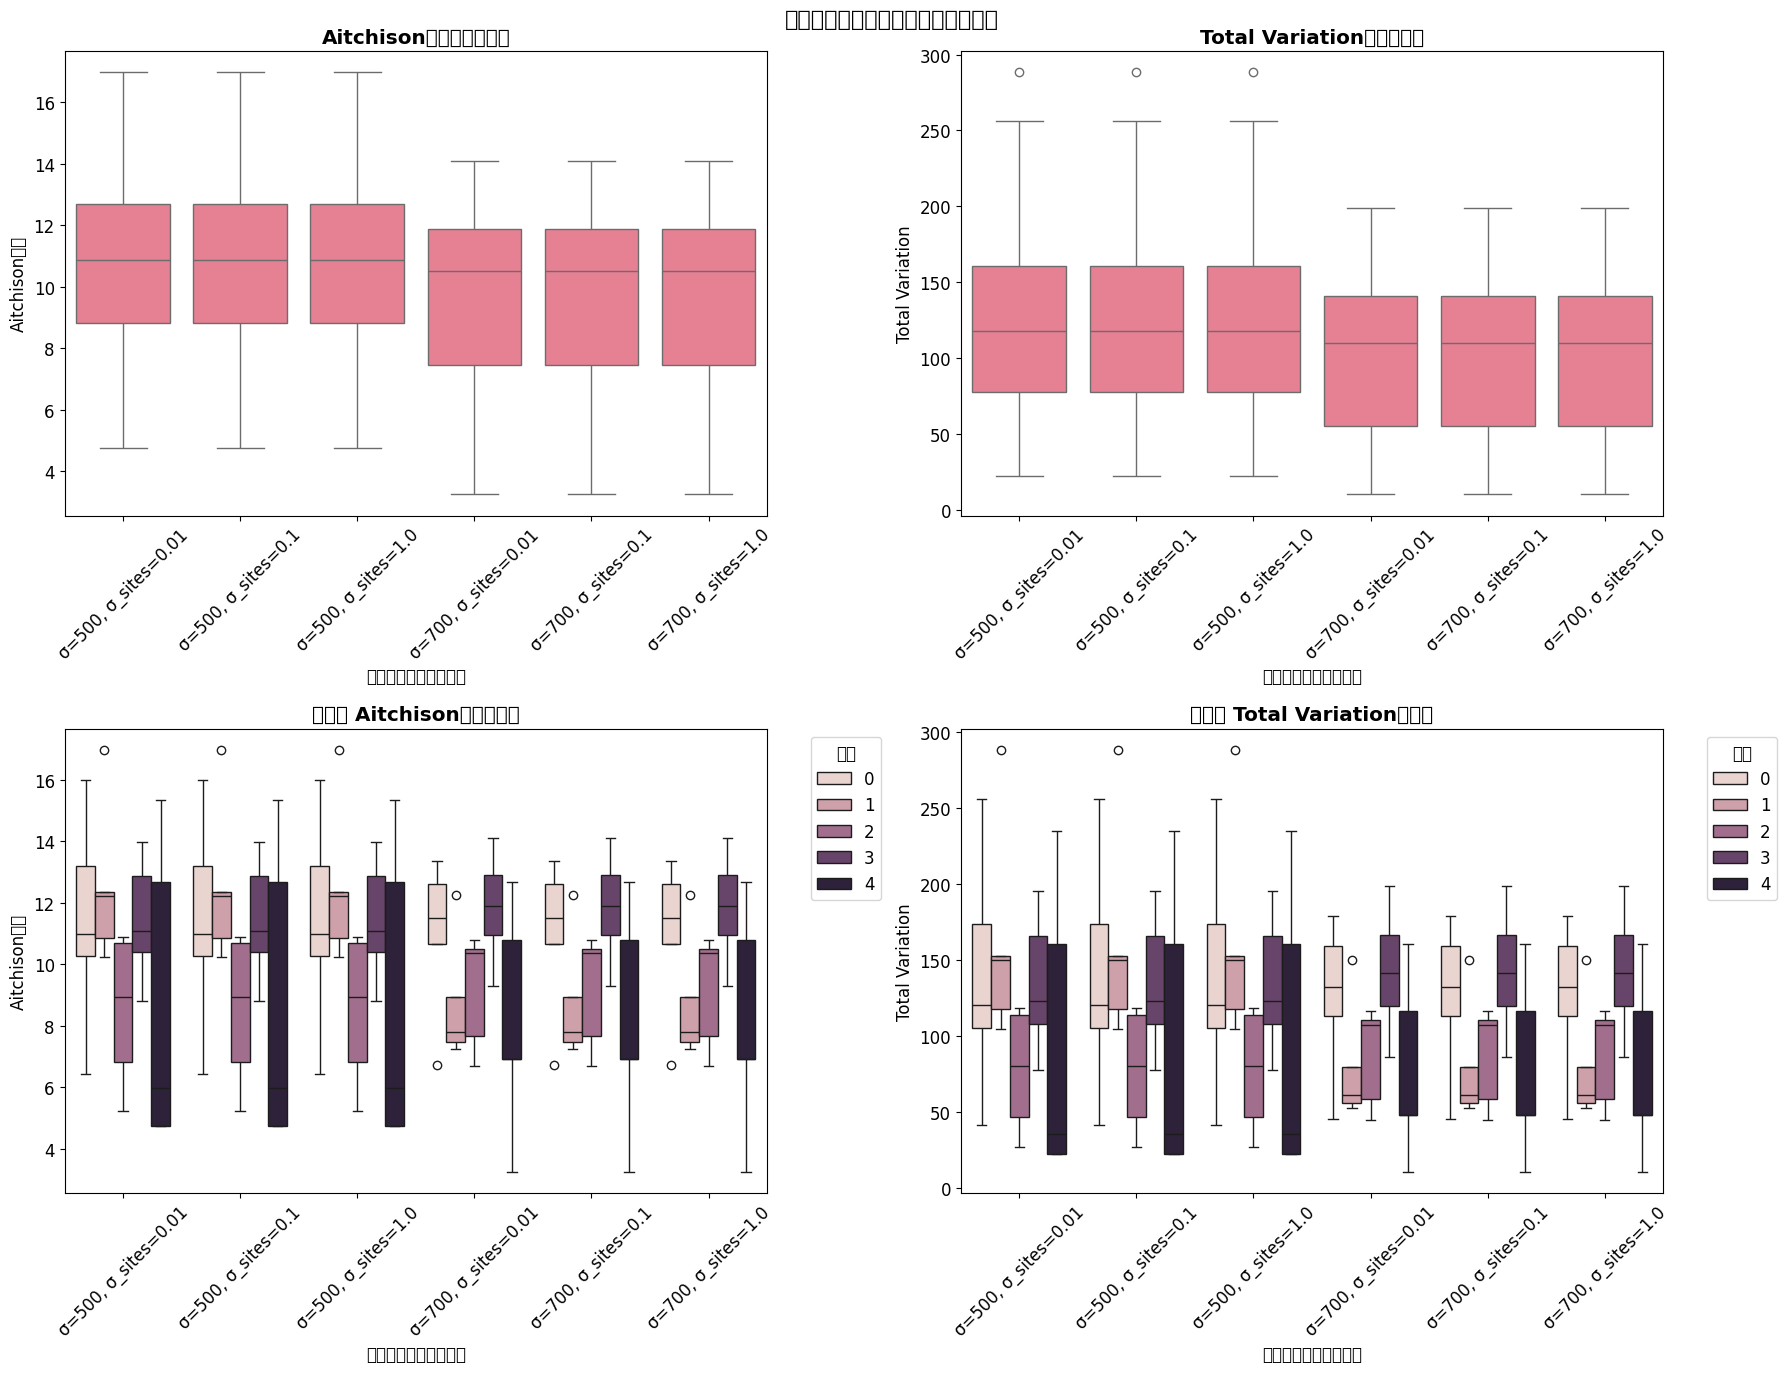

In [9]:
# 箱ひげ図による詳細比較
analyzer.plot_boxplots(figsize=(18, 14))

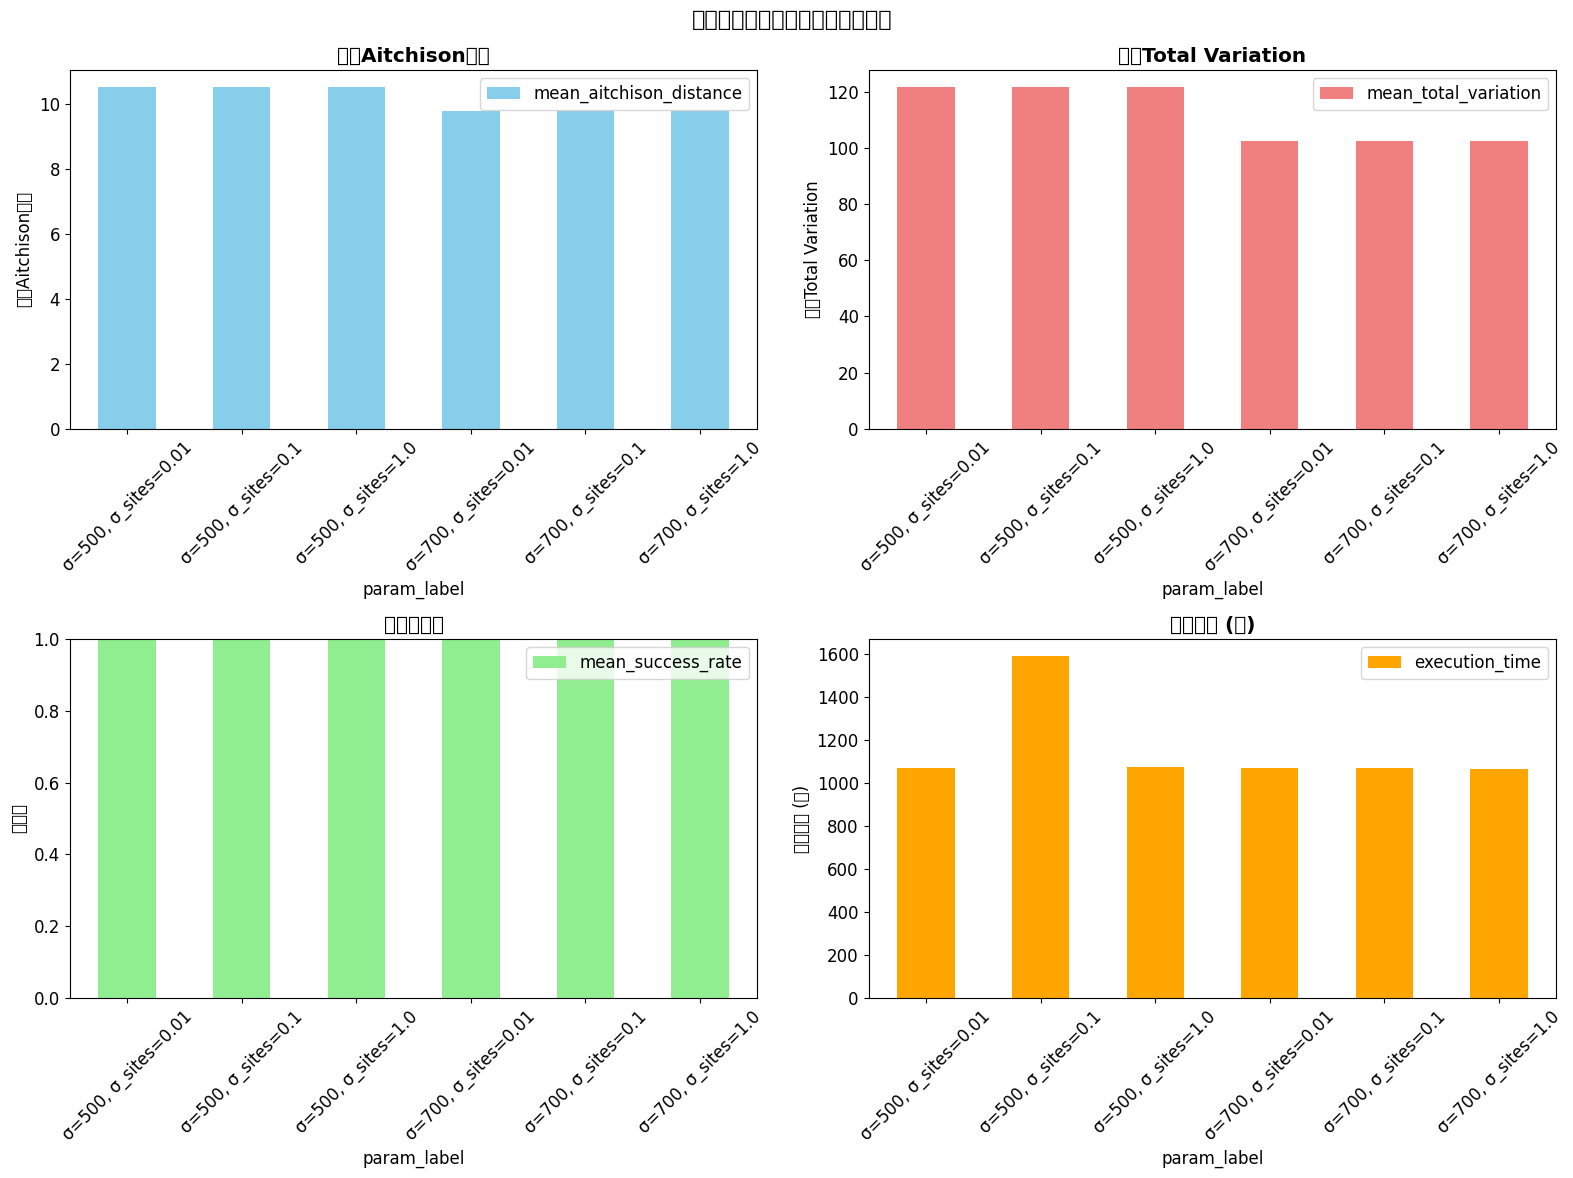

In [10]:
# パフォーマンスサマリーの可視化
analyzer.plot_performance_summary(figsize=(16, 12))

## 9. 最適パラメータの決定

In [11]:
# Aitchison距離基準での最適パラメータ
best_aitchison = analyzer.get_best_parameters(metric="aitchison_distance")

# Total Variation基準での最適パラメータ
best_total_variation = analyzer.get_best_parameters(metric="total_variation")

# 結果の保存
analyzer.save_results()

print("\n=== 推奨パラメータ ===")
print("両方の指標を総合的に考慮して、最適なパラメータを選択してください。")
print("一般的には、Aitchison距離が低く、成功率が高いパラメータが推奨されます。")


=== 最適パラメータ (aitchison_distance基準) ===
sigma: 700
sigma_for_sites: 0.01
平均aitchison_distance: 9.7680
成功率: 1.000
実行時間: 1067.3秒

=== 最適パラメータ (total_variation基準) ===
sigma: 700
sigma_for_sites: 0.01
平均total_variation: 102.4383
成功率: 1.000
実行時間: 1067.3秒

結果を保存しました:
  サマリー: /home/ohta/dev/bayesian_statistics/data/hyperparameter_analysis_summary.csv
  詳細: /home/ohta/dev/bayesian_statistics/data/hyperparameter_analysis_detailed.csv

=== 推奨パラメータ ===
両方の指標を総合的に考慮して、最適なパラメータを選択してください。
一般的には、Aitchison距離が低く、成功率が高いパラメータが推奨されます。


## 10. まとめ

In [12]:
print("\n" + "=" * 80)
print("   LOOCV ハイパーパラメータ最適化結果のまとめ")
print("=" * 80)

print("\n【実験設定】")
print(f"  評価パラメータ数: {len(parameter_combinations)} 組み合わせ")
print(f"  評価時期数: {len(target_periods)} 時期")
print(f"  各時期の試行回数: {loocv_config.n_trials} 回")
print(f"  総試行回数: {len(df_detailed)} 回")

successful_combinations = len([r for r in hp_evaluator.results if "error" not in r])
print("\n【実行結果】")
print(f"  成功した組み合わせ: {successful_combinations}/{len(parameter_combinations)}")
print(f"  平均実行時間: {df_summary['execution_time'].mean():.1f}秒/組み合わせ")
print(f"  総実行時間: {df_summary['execution_time'].sum():.1f}秒")

print("\n【最適パラメータ（Aitchison距離基準）】")
print(f"  sigma: {best_aitchison['sigma']}")
print(f"  sigma_for_sites: {best_aitchison['sigma_for_sites']}")
print(f"  平均Aitchison距離: {best_aitchison['metric_value']:.4f}")
print(f"  成功率: {best_aitchison['success_rate']:.3f}")

print("\n【最適パラメータ（Total Variation基準）】")
print(f"  sigma: {best_total_variation['sigma']}")
print(f"  sigma_for_sites: {best_total_variation['sigma_for_sites']}")
print(f"  平均Total Variation: {best_total_variation['metric_value']:.4f}")
print(f"  成功率: {best_total_variation['success_rate']:.3f}")

print("\n【出力ファイル】")
print(f"  評価結果JSON: {results_file}")
print(f"  サマリーCSV: {os.path.join(data_dir, 'hyperparameter_analysis_summary.csv')}")
print(f"  詳細CSV: {os.path.join(data_dir, 'hyperparameter_analysis_detailed.csv')}")

print("\n" + "=" * 80)
print("この結果を基に、モデル3のハイパーパラメータを決定してください。")
print("=" * 80)


   LOOCV ハイパーパラメータ最適化結果のまとめ

【実験設定】
  評価パラメータ数: 6 組み合わせ
  評価時期数: 5 時期
  各時期の試行回数: 5 回
  総試行回数: 150 回

【実行結果】
  成功した組み合わせ: 6/6
  平均実行時間: 1155.8秒/組み合わせ
  総実行時間: 6934.8秒

【最適パラメータ（Aitchison距離基準）】
  sigma: 700
  sigma_for_sites: 0.01
  平均Aitchison距離: 9.7680
  成功率: 1.000

【最適パラメータ（Total Variation基準）】
  sigma: 700
  sigma_for_sites: 0.01
  平均Total Variation: 102.4383
  成功率: 1.000

【出力ファイル】
  評価結果JSON: None
  サマリーCSV: /home/ohta/dev/bayesian_statistics/data/hyperparameter_analysis_summary.csv
  詳細CSV: /home/ohta/dev/bayesian_statistics/data/hyperparameter_analysis_detailed.csv

この結果を基に、モデル3のハイパーパラメータを決定してください。
